In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.hamiltonians import FermionHamiltonian

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"

import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry.ucc import (
    convert_to_h_integrals,
    transform_integrals_to_new_basis,
)
from qat.fermion.chemistry.ucc_deprecated import (
    get_active_space_hamiltonian,
    get_cluster_ops_and_init_guess,
)
from qat.fermion.transforms import (
    get_bk_code,
    get_jw_code,
    get_parity_code,
    recode_integer,
    transform_to_bk_basis,
    transform_to_jw_basis,
    transform_to_parity_basis,
)

from openvqe.common_files.generator_excitations import (
    singlet_gsd,
    singlet_sd,
    singlet_upccgsd,
    spin_complement_gsd,
    spin_complement_gsd_twin,
    uccsd,
)

In [2]:
import numpy as np


def get_parameters(molecule_symbol):
    if molecule_symbol == "LIH":
        r = 1.45
        geometry = [("Li", (0, 0, 0)), ("H", (0, 0, r))]
        charge = 0
        spin = 0
        #basis = "sto-3g"
        basis = "sto-3g"
    elif molecule_symbol == "H2":
        r = 0.75
        geometry = [("H", (0, 0, 0)), ("H", (0, 0, r))]
        charge = 0
        spin = 0
        basis = "sto-3g"
    elif molecule_symbol == "H4":
        # H4
        r = 0.85
        geometry = [
            ("H", (0, 0, 0)),
            ("H", (0, 0, 1 * r)),
            ("H", (0, 0, 2 * r)),
            ("H", (0, 0, 3 * r)),
        ]
        charge = 0
        spin = 0
        basis = "sto-3g"
    elif molecule_symbol == "H6":
        r = 4.5
        print("r is:", r)
        geometry = [
            ("H", (0, 0, 0)),
            ("H", (0, 0, 1 * r)),
            ("H", (0, 0, 2 * r)),
            ("H", (0, 0, 3 * r)),
            ("H", (0, 0, 4 * r)),
            ("H", (0, 0, 5 * r)),
        ]
        charge = 0
        spin = 0
        basis = "sto-3g"
    elif molecule_symbol == "BeH2":
        r = 1.4
        geometry = [("Be", (0, 0, 0 * r)), ("H", (0, 0, r)), ("H", (0, 0, -r))]
        charge = 0
        spin = 0
        basis = "sto-3g"
    
    return r, geometry, charge, spin, basis


In [3]:
import scipy.optimize
from qat.fermion.chemistry.ucc_deprecated import build_ucc_ansatz
from qat.lang.AQASM import Program
from qat.qpus import get_default_qpu
from openvqe.common_files.circuit import efficient_fermionic_ansatz, efficient_qubit_ansatz, count

def action_quccsd_fermionic(theta_current, hamiltonian_sp, cluster_ops, hf_init_sp):
    """
    It returns the energy from the qubit coupled cluster ansatz which are obtained from common_files.circuit

    Parameters
    ----------
    theta_0: List<float>
        the Parameters of the cluster operators
    
    hamiltonian_sp: Hamiltonian
            Hamiltonian in the spin representation
        
    cluster_ops: list[Hamiltonian]
        list of fermionic cluster operators
    
    hf_init_sp: int
        the integer corresponds to the hf_init (The Hartree-Fock state in integer representation) obtained by using
        "qat.fermion.transforms.record_integer".
    
    Returns
    --------
        res.value: float
            the resulted energy

    """
    qpu = 0
    prog = 0
    prog = Program()
    q = prog.qalloc(hamiltonian_sp.nbqbits)
    ket_hf = binary_repr(hf_init_sp)
    list_ket_hf = [int(c) for c in ket_hf]
    # print(list_ket_hf)
    for j in range(hamiltonian_sp.nbqbits):
        if int(list_ket_hf[j] == 1):
            prog.apply(X, q[j])
    list_exci = []
    for j in cluster_ops:
        s = j.terms[0].qbits
        list_exci.append(s)
    qpu = get_default_qpu()
    qprog = efficient_fermionic_ansatz(q, prog, list_exci, theta_current)
    circ = qprog.to_circ()

    return circ


def action_quccsd_qubit(theta_current, hamiltonian_sp, cluster_ops, hf_init_sp):
    """
    It returns the energy from the qubit coupled cluster ansatz which are obtained from common_files.circuit

    Parameters
    ----------
    theta_0: List<float>
        the Parameters of the cluster operators
    
    hamiltonian_sp: Hamiltonian
            Hamiltonian in the spin representation
        
    cluster_ops: list[Hamiltonian]
        list of fermionic cluster operators
    
    hf_init_sp: int
        the integer corresponds to the hf_init (The Hartree-Fock state in integer representation) obtained by using
        "qat.fermion.transforms.record_integer".
    
    Returns
    --------
        res.value: float
            the resulted energy

    """
    qpu = 0
    prog = 0
    prog = Program()
    q = prog.qalloc(hamiltonian_sp.nbqbits)
    ket_hf = binary_repr(hf_init_sp)
    list_ket_hf = [int(c) for c in ket_hf]
    # print(list_ket_hf)
    for j in range(hamiltonian_sp.nbqbits):
        if int(list_ket_hf[j] == 1):
            prog.apply(X, q[j])
    list_exci = []
    for j in cluster_ops:
        s = j.terms[0].qbits
        list_exci.append(s)
    qpu = get_default_qpu()
    qprog = efficient_qubit_ansatz(q, prog, list_exci, theta_current)
    circ = qprog.to_circ()

    return circ

In [4]:
import numpy as np
from scipy.sparse.linalg import eigs

# reference ket
def from_ket_to_vector(ket):
    state_vector = [1]
    for i in ket:
        qubit_vector = [not i, i]
        state_vector = np.kron(state_vector, qubit_vector)
    return state_vector


def get_reference_ket(hf_init_sp):
    ket_hf = binary_repr(hf_init_sp)
    list_ket_hf = [int(c) for c in ket_hf]
    reference_state = from_ket_to_vector(list_ket_hf)
    sparse_reference_state = scipy.sparse.csr_matrix(
        reference_state, dtype=complex
    ).transpose()
    return sparse_reference_state





def get_optimization_func(circ, qpu, H_sp, method, nqbits, psi0, energy_list, fid_list):
    # below, I show an example of minimization of the energy where I store the energy and fidelity for each parameter
    # I use a gradient-free procedure.
    def my_func(x):
        """returns energy given parameter x, and stores it + the fidelity of state"""
        circ1 = circ.bind_variables(
            {k: v for k, v in zip(sorted(circ.get_variables()), x)}
        )
        res0 = qpu.submit(circ1.to_job(observable=H_sp))
        energy = res0.value
        energy_list[method].append(energy)

        # additional computation to compute fidelity (just for my own information)
        res = qpu.submit(circ1.to_job())
        psi = np.zeros((2**nqbits,), complex)
        for sample in res:
            psi[sample.state.int] = sample.amplitude
        fid = abs(psi.conj().dot(psi0)) ** 2
        fid_list[method].append(fid)

        return energy

    return my_func


def get_grad_func(circ, qpu, H_sp):
    # here I show a gradient-based minimization strategy
    def my_grad(x):
        grads = circ.to_job(observable=H_sp).gradient()
        grad_list = []
        for var_name in sorted(circ.get_variables()):
            list_jobs = grads[var_name]
            # list_jobs contains jobs to compute E(theta+pi/2) and E(theta-pi/2)
            # the gradient w.r.t theta is then 0.5 (E(theta+pi/2) - E(theta-pi/2))
            grad = 0.0
            for ind in range(len(list_jobs)):
                circ1 = list_jobs[ind].circuit.bind_variables(
                    {k: v for k, v in zip(circ.get_variables(), x)}
                )
                job = circ1.to_job(observable=list_jobs[ind].observable)
                res = qpu.submit(job)
                grad += 0.5 * res.value
            grad_list.append(grad)
        return grad_list

    return my_grad



def compute_eigen_values(H_sp):
    # to compute the eigen values and eigen vectors
    eigvals, eigvec = np.linalg.eigh(H_sp.get_matrix(sparse=False))
    E0 = min(eigvals)
    print("min eigval = ", E0)
    psi0 = eigvec[:, np.argmin(eigvals)]
    return E0, psi0



def compute_eigen_values_sparse(hamiltonian_sp):
    # to compute the eigen values and eigen vectors
    hamiltonian = hamiltonian_sp.get_matrix(sparse=True)
    eigvals, eigvec = scipy.sparse.linalg.eigs(hamiltonian, k=1, which="SR")
    E0 = min(eigvals).real
    print("min eigval = ", E0)
    psi0 = eigvec[:, np.argmin(eigvals)]
    return E0, psi0



In [5]:
r, geometry, charge, spin, basis = get_parameters('LIH')

rdm1, orbital_energies, nuclear_repulsion,\
nels, one_body_integrals, two_body_integrals, info = perform_pyscf_computation(
        geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

print("Number of qubits before active space selection = ", rdm1.shape[0]*2)
print("rdm1", rdm1)
print("info:", info)

## We convert the previous inputs to a fermionic Hamiltonian
hpq, hpqrs = convert_to_h_integrals(one_body_integrals, two_body_integrals)
H = ElectronicStructureHamiltonian(hpq, hpqrs, constant_coeff=nuclear_repulsion)

H_sp = transform_to_jw_basis(H)
nqbits = H_sp.nbqbits
print("nqbits", nqbits)

E0, psi0 = compute_eigen_values_sparse(H_sp)
## We construct the "cluster operators" needed for a UCC ansatz:
# First, we expand to NOONs and orbital energies to take spin-degeneracy
# into account
noons, basis_change = np.linalg.eigh(rdm1)
noons = list(reversed(noons))
noons_full, orb_energies_full = [], []
for ind in range(len(noons)):
    noons_full.extend([noons[ind], noons[ind]])
    orb_energies_full.extend([orbital_energies[ind], orbital_energies[ind]])

# we construct the cluster operators, and initial guess for
# the UCC variational parameter
cluster_ops, theta_0, hf_init = get_cluster_ops_and_init_guess(nels, noons_full, orb_energies_full, H.hpqrs)


cluster_ops_sp = [transform_to_jw_basis(t_o) for t_o in cluster_ops]

hf_init_sp = recode_integer(hf_init, get_jw_code(H_sp.nbqbits))

prog = construct_ucc_ansatz(cluster_ops_sp, hf_init_sp, n_steps=1)
circ = prog.to_circ()
qpu = get_default_qpu()







## optimize

res = {}
energy_list, fid_list = {}, {}
for method in ["L-BFGS-B", "BFGS"]:
    energy_list[method], fid_list[method] = [], []
    my_func = get_optimization_func(circ, qpu, H_sp, method, nqbits, psi0, energy_list, fid_list)
    my_grad = get_grad_func(circ, qpu, H_sp)
    res[method] = scipy.optimize.minimize(my_func, jac=my_grad, x0=theta_0, method=method)









"-------------------------" "-------------------------" "-------------------------" "-------------------------"
"""
theta_non_zero = [x for x in theta_0 if x != 0]

print(len(theta_non_zero))

cluster_ops_double = [] 

for observable in cluster_ops:
    # Filter out terms where the operation is 'Cc'
    filtered_terms = [term for term in observable.terms if term.op != 'Cc']
    # Create a new observable with the filtered terms 
    new_observable = FermionHamiltonian(nqbits = nqbits, 
                                            terms=filtered_terms, 
                                            constant_coeff=observable.constant_coeff, 
                                            )
    cluster_ops_double.append(new_observable)


cluster_ops_double = []

for ht in H.terms:
    for observable in cluster_ops:
        for i in range(2):  # Assuming each cluster_op has exactly two terms, based on your code structure
            term = observable.terms[i]
            # Check if operations and qubits match, and the operation is not 'Cc'
            if ht.op == term.op and ht.qbits == term.qbits and term.op != 'Cc':
                if i == 0:
                    cluster_ops_double.append(observable)

# Print each cluster operation in new_cluster_ops
for i in cluster_ops_double:
    print(i)

# Print the length of new_cluster_ops to see how many operations are left
print(len(cluster_ops_double))



theta = [prog.new_var(float, f"\\theta_{i}") for i in range(len(theta_non_zero))]

cluster_ops_sp_double = [transform_to_jw_basis(t_o) for t_o in cluster_ops_double]

    
prog = construct_ucc_ansatz(cluster_ops_sp_double, hf_init_sp, n_steps=1)
#circ_double = prog.to_circ()


res_d = {}
energy_list_d, fid_list_d = {}, {}
for method in ["BFGS"]:
    energy_list_d[method], fid_list_d[method] = [], []
    my_func_d = get_optimization_func(circ_double, qpu, H_sp, method, nqbits, psi0, energy_list_d, fid_list_d)
    my_grad_d = get_grad_func(circ_double, qpu, H_sp)
    res_d[method] = scipy.optimize.minimize(my_func_d, jac=my_grad_d, x0=theta_non_zero, method=method)

"""

"-------------------------" "-------------------------" "-------------------------" "-------------------------"

n_steps =1 
prog = Program()


theta = [prog.new_var(float, f"\\theta_{i}") for i in range(len(theta_0))]



circ_double = action_quccsd_fermionic(theta, H_sp, cluster_ops, hf_init_sp)

## optimize

res_d = {}
energy_list_d, fid_list_d = {}, {}
for method in ["BFGS", "L-BFGS-B"]:
    energy_list_d[method], fid_list_d[method] = [], []
    my_func_d = get_optimization_func(circ_double, qpu, H_sp, method, nqbits, psi0, energy_list_d, fid_list_d)
    my_grad_d = get_grad_func(circ_double, qpu, H_sp)
    res_d[method] = scipy.optimize.minimize(my_func_d, jac=my_grad_d, x0=theta_0, method=method)

# PLOT

fig, ax = plt.subplots(figsize=(11, 7))

steps = np.arange(0, 100)


for method in ["BFGS", "L-BFGS-B"]:
    energy_list[method] = np.array(energy_list[method])
    error = np.maximum(energy_list[method] - E0, 1e-16)  # Ensure no values less than 1e-10
    print("The error for the cluster_ops", error)

    energy_list_d[method] = np.array(energy_list_d[method])
    error_d = np.maximum(energy_list_d[method] - E0, 1e-16)
    print("The error for the cluster_ops_double", error_d)

    ax.plot(error, "-o", label= f"UCC energies using [{method}]")
    ax.plot(error_d, "-x", label= f"QUCC energies using [{method}]")

    if error.size > 0:
        ax.fill_between(steps[:len(error)], 1e-6, 1e-1, color="cadetblue", alpha=0.2, interpolate=True, label = f"Chemical Accuracy ")


  
ax.set_xlabel("optimization step")
ax.set_ylabel("Error energy")
ax.set_yscale('log')  

# Set specific ticks on the y-axis

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
ax.grid(True, which="both", ls="--")  # Grid lines for both major and minor ticks






Number of qubits before active space selection =  12
rdm1 [[ 1.99991641e+00 -4.72041935e-04  6.16236070e-04 -1.65543531e-18
   3.24663693e-20 -1.00931853e-03]
 [-4.72041935e-04  1.95975128e+00  6.67931783e-02 -1.77090782e-17
  -3.35357619e-17  8.36228199e-03]
 [ 6.16236070e-04  6.67931783e-02  9.65145221e-03 -5.65915813e-18
  -2.61662980e-18 -1.38257301e-02]
 [-1.65543531e-18 -1.77090782e-17 -5.65915813e-18  1.71140519e-03
   4.59421066e-21  1.07670880e-17]
 [ 3.24663693e-20 -3.35357619e-17 -2.61662980e-18  4.59421066e-21
   1.71140519e-03  3.04751989e-18]
 [-1.00931853e-03  8.36228199e-03 -1.38257301e-02  1.07670880e-17
   3.04751989e-18  2.72580416e-02]]
info: {'MP2': -7.874481034453376, 'FCI': -7.880982314579996, 'HF': -7.862567785542196}
nqbits 12
min eigval =  -7.880982314580039


/var/folders/lk/3s873myd73q2lv3wl49q7n6h0000gn/T/ipykernel_7899/272736257.py:32: UserWarning: This guess_init_state function is deprecated.
  cluster_ops, theta_0, hf_init = get_cluster_ops_and_init_guess(nels, noons_full, orb_energies_full, H.hpqrs)


The error for the cluster_ops [6.08622664e-02 5.58246813e-02 8.83777316e-03 5.49377983e-03
 8.51232960e-04 3.85633759e-04 6.34261990e-05 6.16668935e-05
 3.36324006e-05 2.75534605e-05 2.43151545e-05 2.27153164e-05
 2.25705671e-05 2.24781856e-05 2.24759860e-05 2.24744286e-05
 2.24742691e-05]
The error for the cluster_ops_double [0.05783631 0.01985352 0.0098478  0.00557971 0.00385649 0.00220009
 0.00174893 0.00147564 0.00139438 0.00133847 0.00131846 0.00131007
 0.00130821 0.00130763 0.0013075  0.00130747 0.00130747 0.00130747]
The error for the cluster_ops [6.08622664e-02 1.06964895e+00 2.88347234e-02 2.28210288e-03
 7.14039912e-04 1.13963124e-04 4.38057569e-05 3.31457494e-05
 2.74849571e-05 2.37163168e-05 2.43498129e-05 2.29925185e-05
 2.25143101e-05 2.24806929e-05 2.24752116e-05 2.24744198e-05]
The error for the cluster_ops_double [0.05783631 0.45137447 0.03373274 0.0184358  0.005968   0.00459654
 0.00264567 0.00178579 0.00159724 0.00137085 0.00133711 0.00131677
 0.001311   0.00130819 0

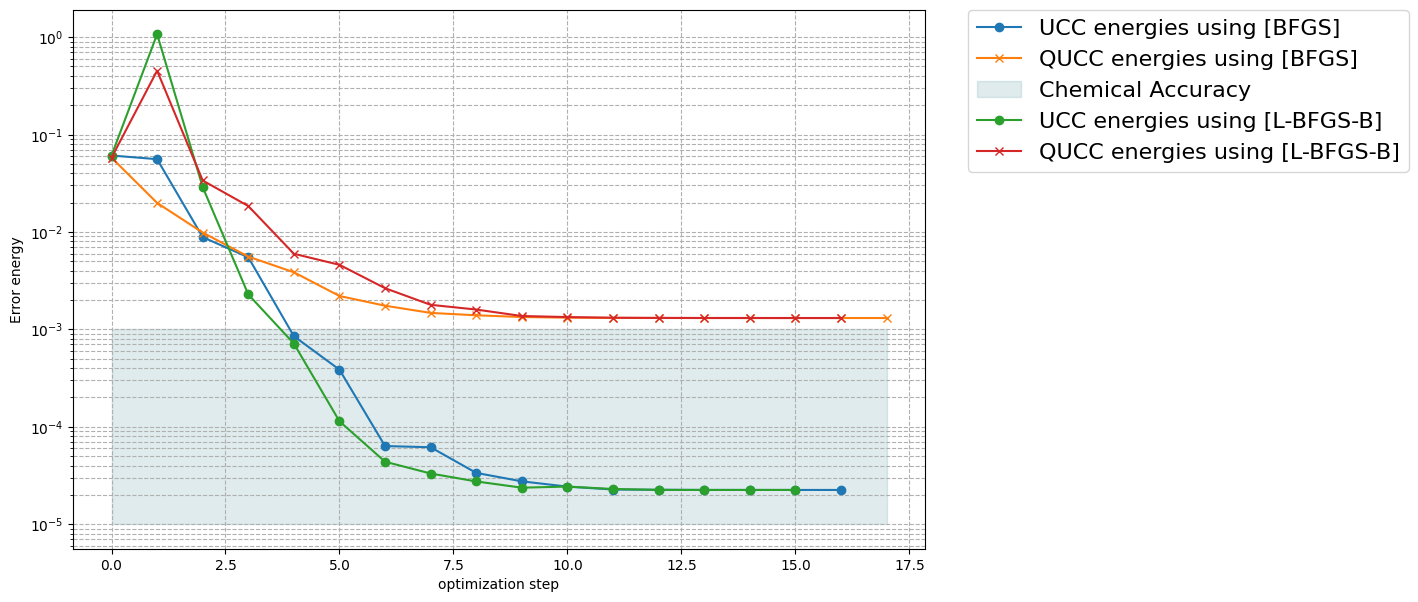

In [ ]:
fig, ax = plt.subplots(figsize=(11, 7))

steps = np.arange(0, 100)
for method in ["BFGS", "L-BFGS-B"]:
    energy_list[method] = np.array(energy_list[method])
    error = np.maximum(energy_list[method] - E0, 1e-16)  # Ensure no values less than 1e-10
    print("The error for the cluster_ops", error)

    energy_list_d[method] = np.array(energy_list_d[method])
    error_d = np.maximum(energy_list_d[method] - E0, 1e-16)
    print("The error for the cluster_ops_double", error_d)

    ax.plot(error, "-o", label= f"UCC energies using [{method}]")
    ax.plot(error_d, "-x", label= f"QUCC energies using [{method}]")

    if method == "BFGS" and error_d.size > 0:
        ax.fill_between(steps[:len(error_d)], 1e-5, 1e-3, color="cadetblue", alpha=0.2, interpolate=True, label = f"Chemical Accuracy ")


  
ax.set_xlabel("optimization step")
ax.set_ylabel("Error energy")
ax.set_yscale('log')  

# Set specific ticks on the y-axis

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=16)
ax.grid(True, which="both", ls="--")  # Grid lines for both major and minor ticks

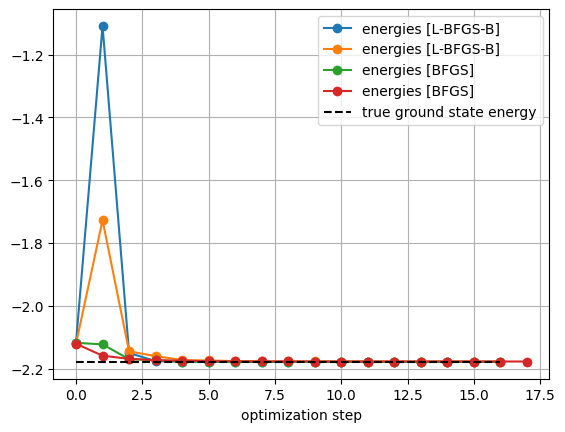

In [ ]:
for method in ["L-BFGS-B","BFGS"]:
    plt.plot(energy_list[method], "-o", label= f"energies [{method}]")
    plt.plot(energy_list_d[method], "-o", label= f"energies [{method}]")

    #plt.plot(fid_list[method], "-s" , label="fidelity w.r.t true ground state")
plt.plot([E0]*len(energy_list[method]), "k--", label = "true ground state energy")
plt.xlabel("optimization step")
plt.legend()
plt.grid()

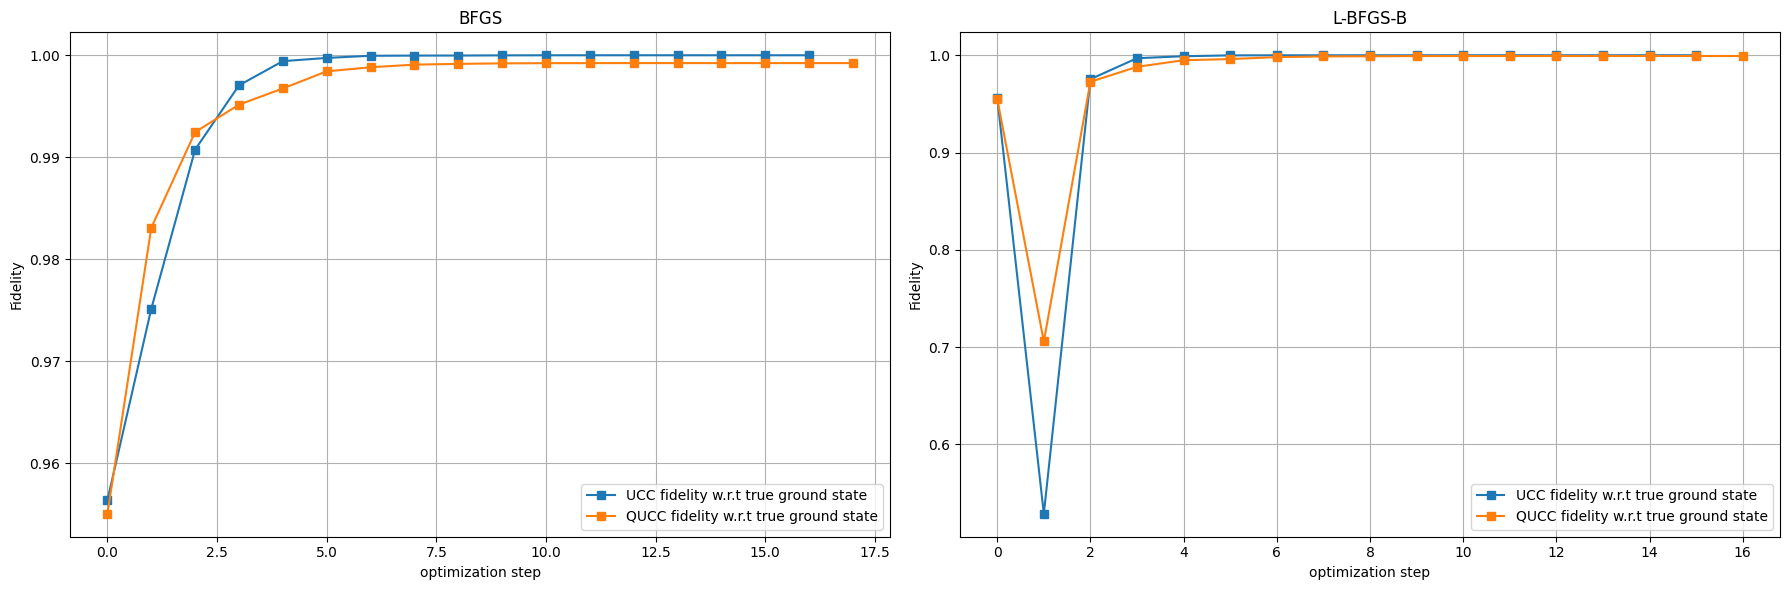

In [ ]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Method "BFGS"
method = "BFGS"
axes[0].plot(fid_list[method], "-s" , label="UCC fidelity w.r.t true ground state")
axes[0].plot(fid_list_d[method], "-s" , label="QUCC fidelity w.r.t true ground state")
axes[0].set_xlabel("optimization step")
axes[0].set_ylabel("Fidelity")
axes[0].legend()
axes[0].grid()
axes[0].set_title("BFGS")

# Method "L-BFGS-B"
method = "L-BFGS-B"
axes[1].plot(fid_list[method], "-s" , label="UCC fidelity w.r.t true ground state")
axes[1].plot(fid_list_d[method], "-s" , label="QUCC fidelity w.r.t true ground state")
axes[1].set_xlabel("optimization step")
axes[1].set_ylabel("Fidelity")
axes[1].legend()
axes[1].grid()
axes[1].set_title("L-BFGS-B")

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'get_new'